In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hottbox.core import Tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error
from tqdm import tqdm
from itertools import product

используем данные акселерометра при совершении каких-то действий.
данные взяты из репозитория
https://github.com/mmalekzadeh/motion-sense/tree/master


видим, что данные 6 мерные, всего 1300 измерений. 3 координатных и 3 измерения ускорения.
Для начала применим разложение с помощью методов для разных компонент и посмотрим, какие собственные числа получаются для разных методов


In [252]:
def get_data(fname):
    """
        Загрузка данных, приведение в нужный формат и отделение данных гироскопа с акселерометром
    """
    data = pd.read_csv(fname)
    data = data.iloc[:, 1:]

    data = data.to_numpy()
    T = data.shape[0]
    new_shape = (T, 4, 3)
    data = np.reshape(data, new_shape)[:, 2:, :]
    tensor_data = Tensor(data)
    return tensor_data

def iterate_ks(tensor_data, ranks_search=[(3, 2, 2)], alg_name='hosvd'):
    """
    итерация по размерам ядра
    """
    if alg_name == 'hosvd':
        alg = HOSVD()
    else:
        alg = HOOI()

    errors = []
    compression_rates = []
    for i,j,k in ranks_search:
        ml_rank = (i,j,k)
        tensor_tucker = alg.decompose(tensor_data, ml_rank)

        size = np.prod(ml_rank)
        for fmat in tensor_tucker.fmat:
            size += np.prod(fmat.shape)

        error = residual_rel_error(tensor_data, tensor_tucker)
        compression_rate = size / np.prod(tensor_data.shape)
        errors.append(error)
        compression_rates.append(compression_rate)
    return errors, compression_rates


## Посмотрим на данные

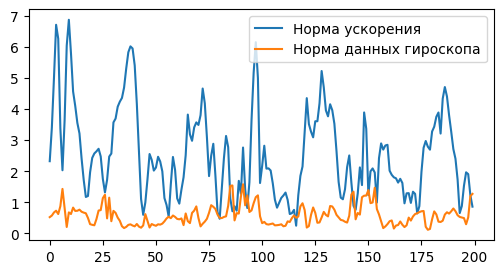

In [193]:
sample__data = get_data('./A_DeviceMotion_data/A_DeviceMotion_data/ups_3/sub_2.csv')
plt.figure(figsize=(6, 3))
plt.plot(np.linalg.norm(sample__data[:200, 0, :], axis=1), label='Норма ускорения')
plt.plot(np.linalg.norm(sample__data[:200, 1, :], axis=1), label='Норма данных гироскопа')
plt.legend()

## Посмотрим на работу при заданном мультиранге (3, 2, 2)

In [347]:
folder_name = "./A_DeviceMotion_data/A_DeviceMotion_data/jog_16/"

rez = {}
data_numbers = range(1, 25) 
ml_ranks = [(3, 2, 2)]
for i in tqdm(data_numbers):
    datapath = folder_name+f"sub_{i}.csv"
    tensor_data = get_data(datapath)
    sub_rez = {}
    for alg_name in ['hosvd', 'hooi']:
        err, comp_rate = iterate_ks(tensor_data, ml_ranks, alg_name=alg_name)
        sub_rez["compression"] = comp_rate
        sub_rez[alg_name] = err
    rez[i] = sub_rez

100%|██████████| 24/24 [00:02<00:00, 10.05it/s]


Мультиранг разложения:  (3, 2, 2)


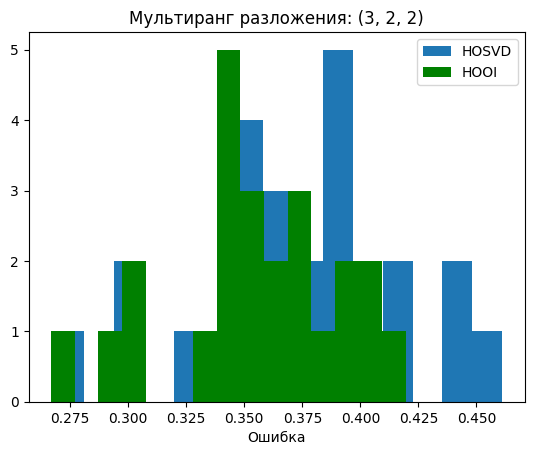

In [348]:
print('Мультиранг разложения: ', ml_ranks[0])
values_1 = [rez[i]['hosvd'][0] for i in data_numbers]
values_2 = [rez[i]['hooi'][0] for i in data_numbers]
plt.hist(values_1, bins=15, label='HOSVD')
plt.hist(values_2, bins=15, color='green', label='HOOI')
plt.xlabel('Ошибка')
plt.title(f'Мультиранг разложения: {ml_ranks[0]}')
plt.legend()
plt.show()

## Анализ зависимости точности от сжатия

In [349]:
rez = {}
data_numbers = range(1, 25) 
ml_ranks = list(product(range(1, 7), range(1, 5), range(1, 6)))
# ml_ranks = [(1, 1, 1), (3, 2, 3)]
for i in tqdm(data_numbers):
    datapath = folder_name+f"sub_{i}.csv"
    tensor_data = get_data(datapath)
    sub_rez = {}
    for alg_name in ['hosvd', 'hooi']:
        err, comp_rate = iterate_ks(tensor_data, ranks_search=ml_ranks, alg_name=alg_name)
        sub_rez["compression"] = comp_rate
        sub_rez[alg_name] = err
    rez[i] = sub_rez

100%|██████████| 24/24 [05:36<00:00, 14.00s/it]


Text(0.5, 1.0, 'Сравнение эффективности сжатия')

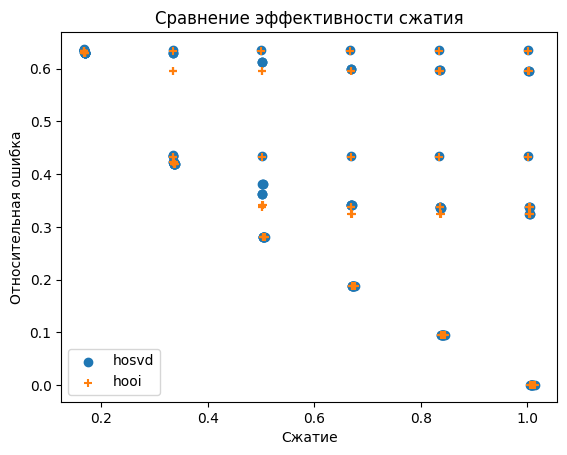

In [350]:
for alg_name in ['hosvd', 'hooi']:
    compressions = rez[1]['compression']
    errors = rez[1][alg_name]
    plt.scatter(compressions, errors, marker=('+' if alg_name=='hooi' else 'o'), label=alg_name)
plt.xlabel('Сжатие')
plt.ylabel('Относительная ошибка')
plt.legend()
plt.title('Сравнение эффективности сжатия')

## Сравнение для выделенных рангов

In [351]:
rez = {}
data_numbers = range(1, 25) 
ml_ranks = list(product(range(1, 7), [4], [4]))
# ml_ranks = [(1, 1, 1), (3, 2, 3)]
for i in tqdm(data_numbers):
    datapath = folder_name+f"sub_{i}.csv"
    tensor_data = get_data(datapath)
    sub_rez = {}
    for alg_name in ['hosvd', 'hooi']:
        err, comp_rate = iterate_ks(tensor_data, ranks_search=ml_ranks, alg_name=alg_name)
        sub_rez["compression"] = comp_rate
        sub_rez[alg_name] = err
    rez[i] = sub_rez

100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


Text(0, 0.5, 'Относительная ошибка')

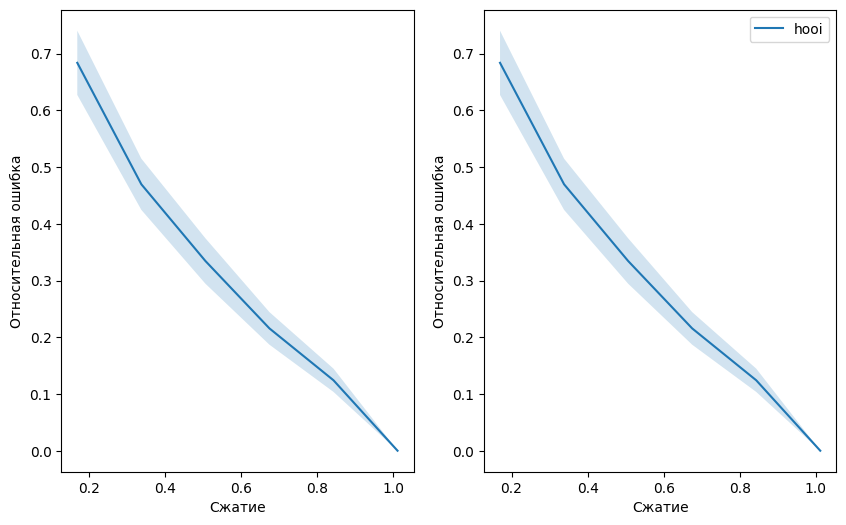

In [355]:
compressions = np.array(rez[1]['compression'])

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

alg_name = 'hosvd'
errors = np.array([rez[i][alg_name] for i in data_numbers])
errors_mean = errors.mean(axis=0)
errors_std = errors.std(axis=0)
axs[0].plot(compressions, errors_mean, label=alg_name)
axs[0].fill_between(compressions, errors_mean - errors_std, errors_mean + errors_std, alpha=0.2)
#axs[0].set_titile(f'Зависимость сжатия для алгоритма {alg_name}')
axs[0].set_xlabel('Сжатие')
axs[0].set_ylabel('Относительная ошибка')

alg_name = 'hooi'
errors = np.array([rez[i][alg_name] for i in data_numbers])
errors_mean = errors.mean(axis=0)
errors_std = errors.std(axis=0)
axs[1].plot(compressions, errors_mean, label=alg_name)
axs[1].fill_between(compressions, errors_mean - errors_std, errors_mean + errors_std, alpha=0.2)
axs[1].legend()
axs[1].set_xlabel('Сжатие')
axs[1].set_ylabel('Относительная ошибка')
# axs[1].set_titile(f'Зависимость сжатия для алгоритма {alg_name}')

In [356]:
rez = {}
data_numbers = range(1, 25) 
ml_ranks = list(product([3], [2], [1, 2, 3]))
# ml_ranks = [(1, 1, 1), (3, 2, 3)]
for i in tqdm(data_numbers):
    datapath = folder_name+f"sub_{i}.csv"
    tensor_data = get_data(datapath)
    sub_rez = {}
    for alg_name in ['hosvd', 'hooi']:
        err, comp_rate = iterate_ks(tensor_data, ranks_search=ml_ranks, alg_name=alg_name)
        sub_rez["compression"] = comp_rate
        sub_rez[alg_name] = err
    rez[i] = sub_rez

100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


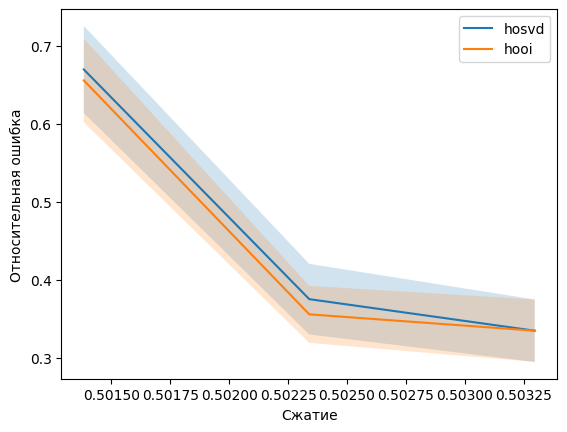

In [357]:
compressions = np.array(rez[1]['compression'])

plt.xlabel('Сжатие')
plt.ylabel('Относительная ошибка')

alg_name = 'hosvd'
errors = np.array([rez[i][alg_name] for i in data_numbers])
errors_mean = errors.mean(axis=0)
errors_std = errors.std(axis=0)
plt.plot(compressions, errors_mean, label=alg_name)
plt.fill_between(compressions, errors_mean - errors_std, errors_mean + errors_std, alpha=0.2)

alg_name = 'hooi'
errors = np.array([rez[i][alg_name] for i in data_numbers])
errors_mean = errors.mean(axis=0)
errors_std = errors.std(axis=0)
plt.plot(compressions, errors_mean, label=alg_name)
plt.fill_between(compressions, errors_mean - errors_std, errors_mean + errors_std, alpha=0.2)
plt.legend()